## WGAN-gp (Wasserstein GAN gradient penalty)
●**Reference Paper**<br>
I.Gulrajani, F.Ahmed,M.Arjovsky, V.Dumoulin and A.Courville, "***Improved Training of Wasserstein GANs***" Proc.NIPS 2017,pp.5769-5779(2017)<br>
https://arxiv.org/pdf/1704.00028.pdf<br><br>
***GAN often suffers from training instability***. The Wasserstein GAN (WGAN) makes progress toward stable training of GANs, but sometimes can still generate only poor samples or fail to converge. These problems are often due to the use of ***weight clipping in WGAN to enforce a Lipschitz constraint on the critic* ***. So, they propose an alternative to clipping weights:***penalize the norm of gradient of the critic*** with respect to its input. They say this method performs better than standard WGAN and enables stable training.<br>
*critic : WGAN calls the discriminator a critic

### Outline of WGAN-gp

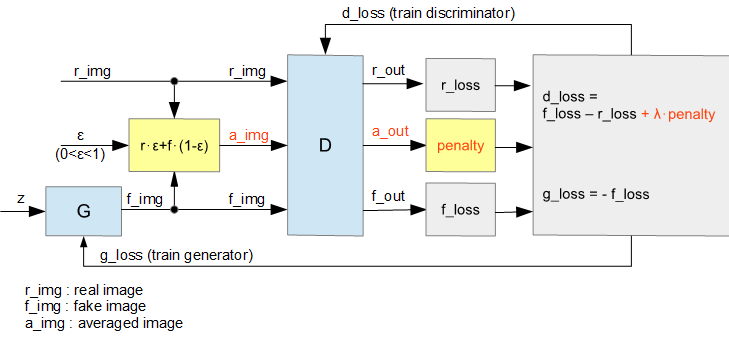

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
from tqdm import tqdm, tqdm_notebook
import glob
import shutil
import time      # time.perf_counter()
import random

import matplotlib.pyplot as plt
import cv2

import xml.etree.ElementTree as ET

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import image

In [ ]:
print(os.listdir("../input"))

## Constants

In [ ]:
kernel_start = time.perf_counter()
kernel_time_limit = 60*60*8.5        #### running time

# image size
img_size = 64
channels = 3
img_shape = (img_size, img_size, channels)    # (64,64,3)

# z(latent variable) size
z_dim = 100
z_shape = (z_dim,)

# gradient penalty coefficient "λ"
penaltyLambda = 10    # d_loss = f_loss - r_loss + λ･penalty

# critic(discriminator) iterations per generator iteration
trainRatio = 5

batch_size = 32        # 16 or 64 better?
rec_interval = 10000

DIR = os.getcwd()
DIRimg = "../input/all-dogs/all-dogs"
DIRanno = "../input/annotation/Annotation"
DIRout = "../output_images"

## Image data loading and clipping Function

In [ ]:
def loadImage(fPath, resize = True):
    img = cv2.imread(fPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # BGR to RGB
    if resize:
        xmin,ymin,xmax,ymax = clipImage(fPath)      # clip to square
        if xmin >= 0:                               # exist Annotation
            img = img[ymin:ymax, xmin:xmax, :]      # [h,w,c]
        # Interpolation method
        if xmax - xmin > img_size:
            interpolation = cv2.INTER_AREA          # shrink
        else:
            interpolation = cv2.INTER_CUBIC         # expantion
        img = cv2.resize(img, (img_size, img_size),
                    interpolation = interpolation)  # resize
    return img

In [ ]:
def clipImage(fPath):
    imgName = os.path.basename(fPath)[:-4].split("_")
    breed = imgName[0]
    dog = imgName[1]
    path = glob.glob(os.path.join(DIRanno, breed + "*", breed +"_" + dog))
    if len(path) > 0:
        tree = ET.parse(path[0])
        root = tree.getroot()    # get <annotation>
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
#        objects = root.findall('object')   # ToDo: correspond multi objects
#        for object in objects:
        object = root.find('object')
        bndbox = object.find('bndbox') 
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        xmin = max(0, xmin - 4)        # 4 : margin
        xmax = min(width, xmax + 4)
        ymin = max(0, ymin - 4)
        ymax = min(height, ymax + 4)

        w = max(xmax - xmin, ymax - ymin, img_size)   # ideal w
        w = min(w, width, height)                     # available w
    
        if w > xmax - xmin:
            xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
            xmax = xmin + w
        if w > ymax - ymin:
            ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
            ymax = ymin + w

    else:
        xmin = -1; ymin = -1; xmax = -1; ymax = -1;     # no annotation ?
        
    return xmin,ymin,xmax,ymax

## Image samples before clipping

In [ ]:
all_fNames = os.listdir(DIRimg)

# image sample
sample_ids = random.sample(range(len(all_fNames)), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
for i, axis in enumerate(axes.flatten()):
    img = loadImage(os.path.join(DIRimg,
                    all_fNames[sample_ids[i]]), resize=False)
    imgplot = axis.imshow(img)
    axis.set_title(all_fNames[sample_ids[i]])
    axis.set_axis_off()
plt.tight_layout()

## Convert Images to Train Data

In [ ]:
# train data
x_train = np.zeros((len(all_fNames),img_size,img_size,3))
for i in tqdm(range(len(all_fNames))):
    path = os.path.join(DIRimg, all_fNames[i])
    x_train[i] = loadImage(path)

x_train = x_train / 255.
print(x_train.shape)

## Image samples after clipping

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
for indx, axis in enumerate(axes.flatten()):
    img = image.array_to_img(x_train[sample_ids[indx]])    # ndarray → PIL
    imgplot = axis.imshow(img)
    axis.set_title(all_fNames[sample_ids[indx]])
    axis.set_axis_off()
plt.tight_layout()

## WGAN-gp Model

In [ ]:
def build_generator():
    input = Input(shape=z_shape)
    x = Dense(8*img_size*img_size, activation="relu")(input)
    x = Reshape((img_size//8, img_size//8, -1))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same",
               use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh",
               use_bias=False,)(x)

    model = Model(input, x)
    print("●generator")
    model.summary()
    return model

In [ ]:
def build_discriminator():
    input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation=None)(x)   # activation = None
    
    model = Model(input, x)
    print("●discriminator")
    model.summary()
    return model

In [ ]:
def build_WGANgp(generator, discriminator):
    #### model
    # generator image(fake image)
    z = Input(shape=z_shape)
    f_img = generator(z)
    f_out = discriminator(f_img)
    # real image
    r_img = Input(shape=img_shape)
    r_out = discriminator(r_img)
    # average image
    epsilon = K.placeholder(shape=(None,1,1,1))
    a_img = Input(shape=(img_shape),
                  tensor = epsilon * r_img + (1-epsilon) * f_img)
    a_out = discriminator(a_img)

    #### loss
    # original critic(discriminator) loss
    r_loss = K.mean(r_out)
    f_loss = K.mean(f_out)
    # gradient penalty  <this is point of WGAN-gp>
    grad_mixed = K.gradients(a_out, [a_img])[0]
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
    grad_penalty = K.mean(K.square(norm_grad_mixed -1))
    penalty = penaltyLambda * grad_penalty
    # d loss
    d_loss = f_loss - r_loss + penalty
    
    #### discriminator update function
    d_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(discriminator.trainable_weights,[],d_loss)
    d_train = K.function([r_img, z, epsilon],
                         [r_loss, f_loss, penalty, d_loss],
                         d_updates)
    
    #### generator update function
    g_loss = -1. * f_loss
    g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(generator.trainable_weights,[],g_loss)
    g_train = K.function([z], [g_loss], g_updates)

    return g_train, d_train

## Build Training Model

In [ ]:
# generator Model
generator = build_generator()
# discriminator Model
discriminator = build_discriminator()
# WGAN-gp Training Model
G_train, D_train = build_WGANgp(generator, discriminator)

## Prepare Training

In [ ]:
# fixed z for confirmation of generated image
z_fix = np.random.normal(0, 1, (64, z_dim)) 

# list for store learning progress data
g_loss_list = []
r_loss_list = []
f_loss_list = []
f_r_loss_list = []
penalty_list = []
d_loss_list = []

# (0～1) → (-1～+1)
X_train = (x_train.astype(np.float32) - 0.5) / 0.5

In [ ]:
def sumple_images(imgs, rows=3, cols=3, figsize=(12,10)):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for indx, axis in enumerate(axes.flatten()):
        img = image.array_to_img(imgs[indx])    # ndarray → PIL
        imgplot = axis.imshow(img)
        axis.set_axis_off()
    plt.tight_layout()

## Perform Training

In [ ]:
iteration = 0
while time.perf_counter() - kernel_start < kernel_time_limit:
    
    #### Discriminator
    for j in range(trainRatio):
        # Generator in
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # Generator out Images
        f_imgs = generator.predict(z)
        # Real Images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        r_imgs = X_train[idx]
        # train the discriminator
        epsilon = np.random.uniform(size = (batch_size, 1,1,1))
        r_loss, f_loss, penalty, d_loss = D_train([r_imgs, z, epsilon])

    #### Generator
    # Generator in
    z = np.random.normal(0, 1, (batch_size, z_dim))
    # train the generator
    g_loss = G_train([z])

    #### Record of learning progress
    # loss
    r_loss_list.append(r_loss)
    f_loss_list.append(f_loss)
    f_r_loss_list.append(f_loss - r_loss)
    penalty_list.append(penalty)
    d_loss_list.append(d_loss)
    # generated image sumple
    if (iteration in [100, 1000]) or (iteration % rec_interval == 0):
        print(f'iteration:{iteration} / d_loss:{d_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}')
        g_imgs = generator.predict(z_fix)
        imgs = g_imgs * 127.5 + 127.5
        sumple_images(imgs, rows=1, cols=7)
        plt.show()

    iteration += 1
    
print("last iteration:",iteration - 1)

In [ ]:
# plot loss
fig, ax = plt.subplots(5, 2, figsize=(8.27,11.69))
for j in range(2):
    ax[0,j].plot(r_loss_list, label="r_los")
    ax[1,j].plot(f_loss_list, label="f_loss")
    ax[2,j].plot(f_r_loss_list, label="f-r_loss")
    ax[3,j].plot(penalty_list, label="penalty")
    ax[4,j].plot(d_loss_list, label="d_loss")
for i in range(5):
    ax[i,0].set_xlim([0,200])
    ax[i,1].set_xlim([200,iteration])
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].legend()
plt.show()

## Submit

In [ ]:
if os.path.exists(DIRout):
    shutil.rmtree(DIRout)
if not os.path.exists(DIRout):
    os.mkdir(DIRout)

In [ ]:
# generate images for submit
n = 10000
batch = 64
for i in tqdm(range(0, n, batch)):
    z = np.random.normal(0,1,size=(batch, z_dim))
    g_imgs = generator.predict(z)
    imgs = g_imgs * 127.5 + 127.5
    for j in range(batch):
        img = image.array_to_img(imgs[j])      # ndarray → PIL 
        img.save(os.path.join(DIRout, 'image_' + str(i+j+1).zfill(5) + '.png'))
        if i+j+1 == n:
            break
print(len(os.listdir(DIRout)))

In [ ]:
# generated DOGs sumple
sumple_images(g_imgs, rows=5, cols=7, figsize=(12,8))

In [ ]:
if os.path.exists('images.zip'):
    os.remove('images.zip')
shutil.make_archive('images', 'zip', DIRout)
print("<END>")